<!-- - Improve the percentage of patients waiting no longer than 18 weeks for treatment to 65% nationally by March 2026, with every trust expected to deliver a minimum 5% point improvement.
- Improve the percentage of patients waiting no longer than 18 weeks for a first appointment to 72% nationally by March 2026, with every trust expected to deliver a minimum 5% point improvement
- Reduce the proportion of people waiting over 52 weeks for treatment to less than 1% of the total waiting list by March 2026

[2025/26 priorities and operational planning guidance](https://www.england.nhs.uk/long-read/2025-26-priorities-and-operational-planning-guidance/) -->

## Questions
- National priorities and success measures for 2025/26 in the 2025/26 priorities and operational planning guidance mentions the following targets:
    - Improve the percentage of patients waiting no longer than 18 weeks for treatment to 65% nationally by March 2026, with every trust expected to deliver a minimum 5% point improvement.
    - Reduce the proportion of people waiting over 52 weeks for treatment to less than 1% of the total waiting list by March 2026

## Import necessary libraries

In [328]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from itertools import product
from typing import List, Dict, Tuple, Optional


In [329]:
excel_file = "dataset.xlsx"

In [330]:
# Load the Excel file
xls = pd.ExcelFile(excel_file)

In [331]:
data_df = pd.read_excel(xls, sheet_name=0)  

In [332]:
print(tabulate(data_df, headers='keys', tablefmt='psql'))

+-----+---------------------+-----------------------------------+-----------------------------------------------------------------+--------------------------------------------+-------------------------------------------+-----------------------+-----------------------+
|     | MonthYear           | Treatment Function                |   Total number of completed pathways (with a known clock start) | Average (median) waiting time (in weeks)   | 95th percentile waiting time (in weeks)   |   Total 18 plus weeks |   Total 52 plus weeks |
|-----+---------------------+-----------------------------------+-----------------------------------------------------------------+--------------------------------------------+-------------------------------------------+-----------------------+-----------------------|
|   0 | 2023-09-01 00:00:00 | General Surgery Service           |                                                             150 | 17.2                                       | 69.5            

In [333]:
numeric_object_cols = ['Average (median) waiting time (in weeks)', '95th percentile waiting time (in weeks)']
for col in numeric_object_cols:
    data_df[col] = pd.to_numeric(data_df[col], errors='coerce')
print(data_df.dtypes)

MonthYear                                                        datetime64[ns]
Treatment Function                                                       object
Total number of completed pathways (with a known clock start)             int64
Average (median) waiting time (in weeks)                                float64
95th percentile waiting time (in weeks)                                 float64
Total 18 plus weeks                                                       int64
Total 52 plus weeks                                                       int64
dtype: object


C:\Users\ajays\AppData\Local\Temp\ipykernel_24980\2895673104.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=avg_wait_sorted.values, y=avg_wait_sorted.index, palette='viridis')
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


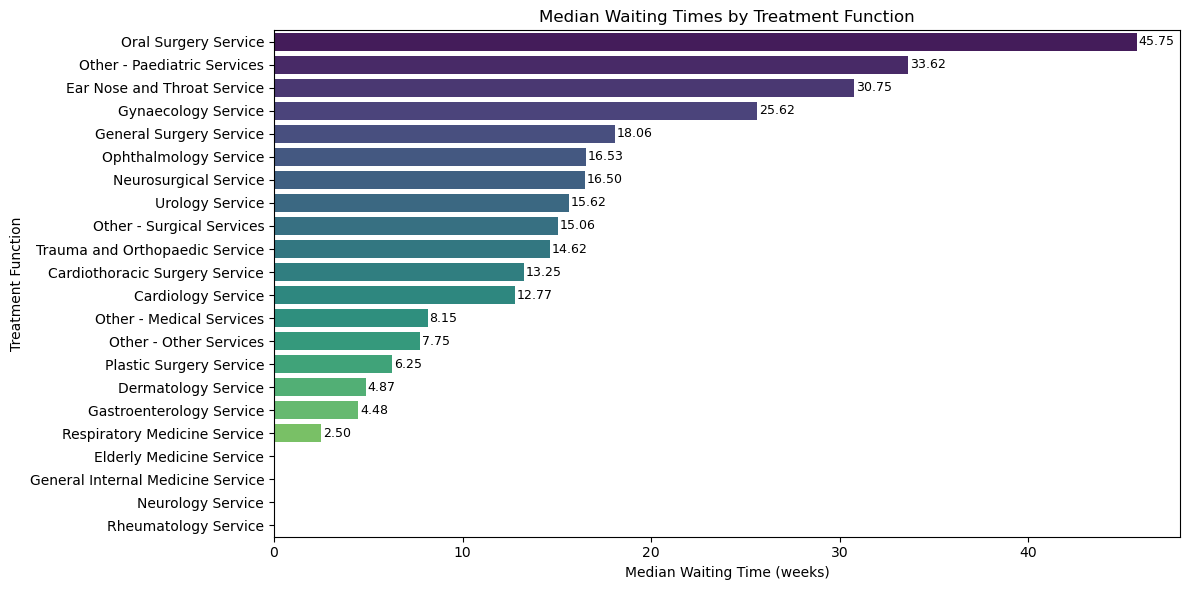

In [334]:
# Group by 'Treatment Function' and calculate the mean of 'Average (median) waiting time (in weeks)'
avg_wait = data_df.groupby('Treatment Function')['Average (median) waiting time (in weeks)'].median()

# Sort in descending order
avg_wait_sorted = avg_wait.sort_values(ascending=False)

# Plot as a bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=avg_wait_sorted.values, y=avg_wait_sorted.index, palette='viridis')
plt.xlabel('Median Waiting Time (weeks)')
plt.ylabel('Treatment Function')
plt.title('Median Waiting Times by Treatment Function')

for i, v in enumerate(avg_wait_sorted.values):
    ax.text(v + 0.1, i, f'{v:.2f}', va='center', fontsize=9)
plt.tight_layout()
plt.show()

C:\Users\ajays\AppData\Local\Temp\ipykernel_24980\924437645.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax_95 = sns.barplot(x=percentile_95_wait_sorted.values, y=percentile_95_wait_sorted.index, palette='magma')


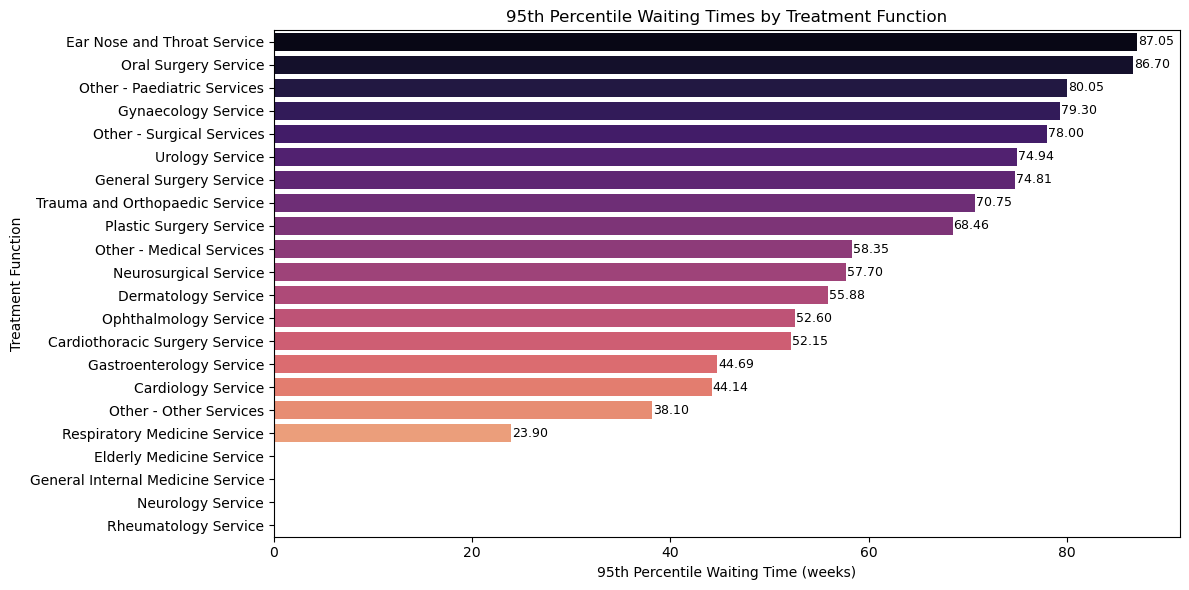

In [335]:
# Group by 'Treatment Function' and calculate the mean of '95th percentile waiting time (in weeks)'
percentile_95_wait = data_df.groupby('Treatment Function')['95th percentile waiting time (in weeks)'].median()

# Sort in descending order
percentile_95_wait_sorted = percentile_95_wait.sort_values(ascending=False)

# Plot as a bar chart
plt.figure(figsize=(12, 6))
ax_95 = sns.barplot(x=percentile_95_wait_sorted.values, y=percentile_95_wait_sorted.index, palette='magma')
plt.xlabel('95th Percentile Waiting Time (weeks)')
plt.ylabel('Treatment Function')
plt.title('95th Percentile Waiting Times by Treatment Function')

for i, v in enumerate(percentile_95_wait_sorted.values):
    if not np.isnan(v):
        ax_95.text(v + 0.1, i, f'{v:.2f}', va='center', fontsize=9)
plt.tight_layout()
plt.show()

C:\Users\ajays\AppData\Local\Temp\ipykernel_24980\1669861721.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax_52 = sns.barplot(x=plus_52_sorted.values, y=plus_52_sorted.index, palette='flare')


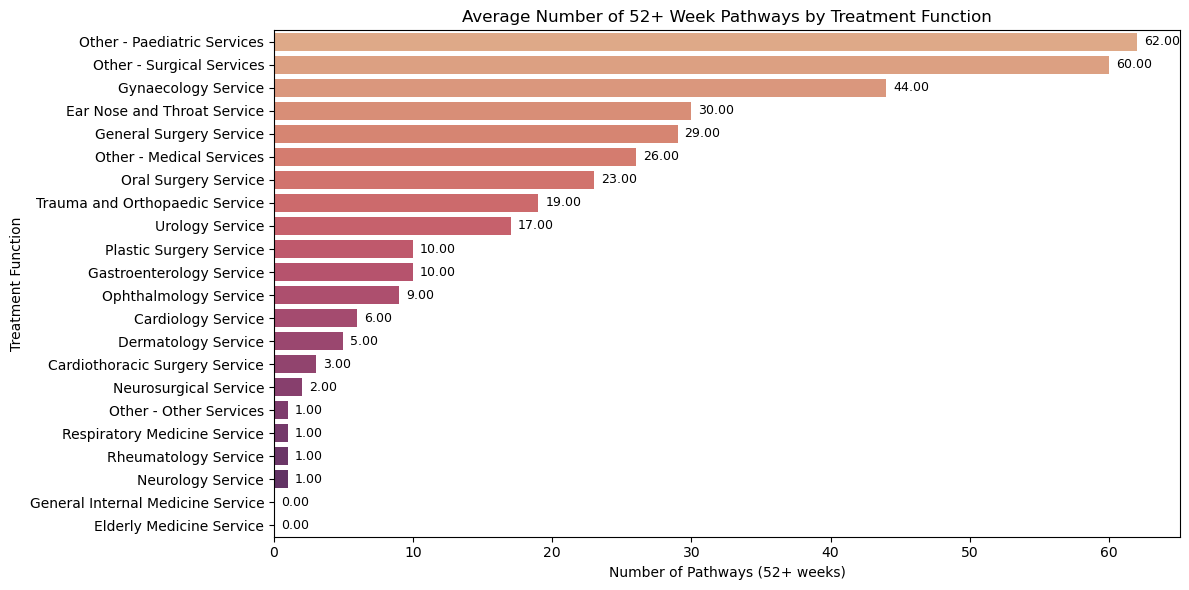

In [336]:
# Group by 'Treatment Function' and calculate the mean of 'Total 52 plus weeks'
plus_52 = data_df.groupby('Treatment Function')['Total 52 plus weeks'].mean()

# Sort in descending order and apply np.ceil for whole numbers
plus_52_sorted = plus_52.sort_values(ascending=False).apply(np.ceil)

# Plot as a bar chart
plt.figure(figsize=(12, 6))
ax_52 = sns.barplot(x=plus_52_sorted.values, y=plus_52_sorted.index, palette='flare')
plt.xlabel('Number of Pathways (52+ weeks)')
plt.ylabel('Treatment Function')
plt.title('Average Number of 52+ Week Pathways by Treatment Function')

for i, v in enumerate(plus_52_sorted.values):
    ax_52.text(v + 0.5, i, f'{v:.2f}', va='center', fontsize=9)
plt.tight_layout()
plt.show()

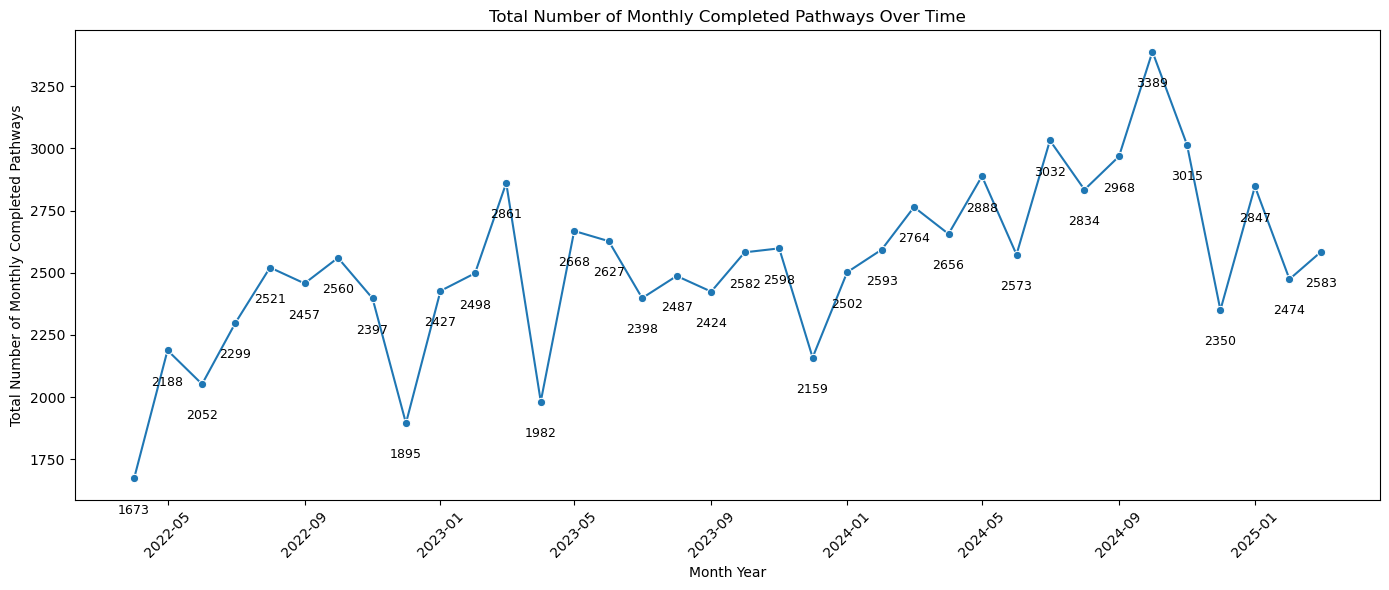

In [337]:
# Group by MonthYear and sum the total number of completed pathways (with a known clock start)
monthly_pathways = data_df.groupby('MonthYear')['Total number of completed pathways (with a known clock start)'].sum()

# Plot the time series with value labels below the points
plt.figure(figsize=(14, 6))
ax = sns.lineplot(x=monthly_pathways.index, y=monthly_pathways.values, marker='o')
plt.xlabel('Month Year')
plt.ylabel('Total Number of Monthly Completed Pathways')
plt.title('Total Number of Monthly Completed Pathways Over Time')
plt.xticks(rotation=45)

# Add value labels below each point
for x, y in zip(monthly_pathways.index, monthly_pathways.values):
    ax.text(x, y - (max(monthly_pathways.values) * 0.03), f'{int(y)}', ha='center', va='top', fontsize=9)

plt.tight_layout()
plt.show()

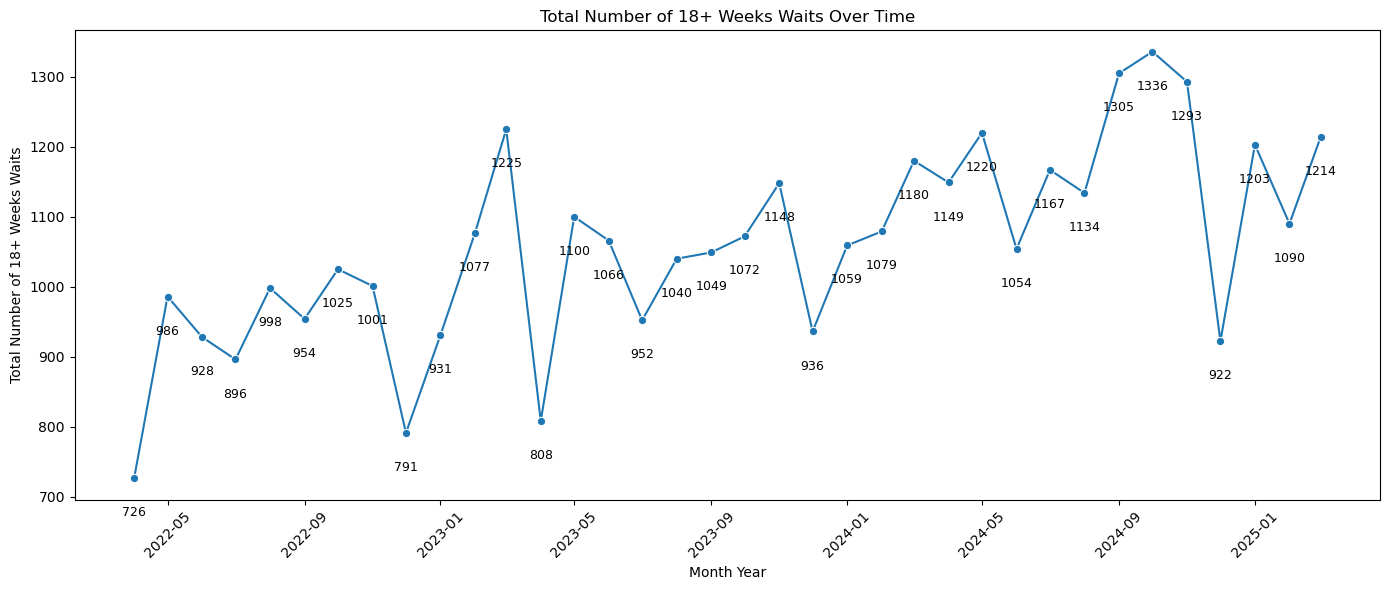

In [338]:
# Group by MonthYear and sum the total number of 18+ weeks waits
monthly_18plus = data_df.groupby('MonthYear')['Total 18 plus weeks'].sum()

# Plot the time series with value labels below the points
plt.figure(figsize=(14, 6))
ax_18 = sns.lineplot(x=monthly_18plus.index, y=monthly_18plus.values, marker='o')
plt.xlabel('Month Year')
plt.ylabel('Total Number of 18+ Weeks Waits')
plt.title('Total Number of 18+ Weeks Waits Over Time')
plt.xticks(rotation=45)

# Add value labels below each point
for x, y in zip(monthly_18plus.index, monthly_18plus.values):
    ax_18.text(x, y - (max(monthly_18plus.values) * 0.03), f'{int(y)}', ha='center', va='top', fontsize=9)

plt.tight_layout()
plt.show()

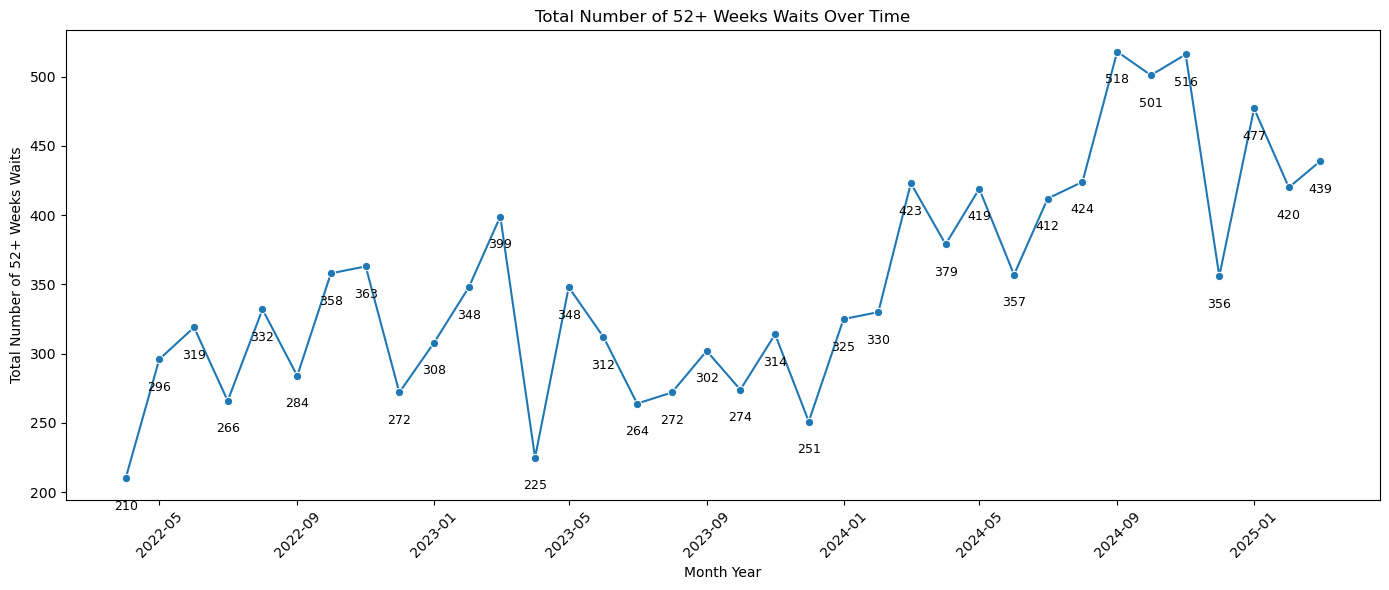

In [339]:
# Group by MonthYear and sum the total number of 52+ weeks waits
monthly_52plus = data_df.groupby('MonthYear')['Total 52 plus weeks'].sum()

# Plot the time series with value labels below the points
plt.figure(figsize=(14, 6))
ax_52plus = sns.lineplot(x=monthly_52plus.index, y=monthly_52plus.values, marker='o')
plt.xlabel('Month Year')
plt.ylabel('Total Number of 52+ Weeks Waits')
plt.title('Total Number of 52+ Weeks Waits Over Time')
plt.xticks(rotation=45)

# Add value labels below each point
for x, y in zip(monthly_52plus.index, monthly_52plus.values):
    ax_52plus.text(x, y - (max(monthly_52plus.values) * 0.03), f'{int(y)}', ha='center', va='top', fontsize=9)

plt.tight_layout()
plt.show()

In [340]:
print(f"The dataset contains the data for {data_df['MonthYear'].nunique()} months from: {data_df['MonthYear'].min().strftime('%Y-%m-%d')} to {data_df['MonthYear'].max().strftime('%Y-%m-%d')}")

The dataset contains the data for 36 months from: 2022-04-01 to 2025-03-01


<!-- ## 18 plus week waits -->

In [341]:
def get_ts(df, col_name):
    """Returns a time series DataFrame with 'MonthYear' as index and specified column."""
    ts = df.copy()
    ts.set_index('MonthYear', inplace=True)
    ts = ts[['Treatment Function', col_name]]
    return ts

In [342]:
waits_18plus_df = get_ts(data_df, 'Total 18 plus weeks')
waits_52plus_df = get_ts(data_df, 'Total 52 plus weeks')
total_pathways_df = get_ts(data_df, 'Total number of completed pathways (with a known clock start)')

In [343]:
def get_plot_data(df):
    """
    Prepares data for financial year analysis by month and adds financial year column.
    
    Args:
        df (pd.DataFrame): Input DataFrame with datetime index
        value_column (str): Name of column containing values to sum
        month_order (list): Custom month order (defaults to financial year April-March)
        
    Returns:
        pd.DataFrame: Processed DataFrame with:
            - year: calendar year
            - month_name: month names in specified order
            - financial_year: formatted as "YYYY/YY"
            - summed values from input column
    """
    # Default financial month order (April to March)
    month_order = ["April", "May", "June", "July", "August", "September", 
                  "October", "November", "December", "January", "February", "March"]

    # Create working copy with target column
    plot_df = df.copy()
    
    # Add month names from index
    plot_df["month_name"] = df.index.month_name()
    
    # Convert to categorical with financial month ordering
    plot_df['month_name'] = pd.Categorical(
        plot_df['month_name'], 
        categories=month_order, 
        ordered=True
    )
    
    # Add calendar year from index
    plot_df["year"] = plot_df.index.year
    
    # Group by year and month, summing values
    result_df = plot_df.groupby(['year', 'month_name']).sum().reset_index()
    
    # Add financial year column
    def get_financial_year(row):
        if row['month_name'] in ['January', 'February', 'March']:
            return f"{row['year']-1}/{str(row['year'])[-2:]}"
        else:
            return f"{row['year']}/{str(row['year']+1)[-2:]}"
    
    result_df['financial_year'] = result_df.apply(get_financial_year, axis=1)
    
    return result_df

In [344]:
plot_df_18plus = get_plot_data(waits_18plus_df)
plot_df_52plus = get_plot_data(waits_52plus_df)
plot_df_total = get_plot_data(total_pathways_df)

C:\Users\ajays\AppData\Local\Temp\ipykernel_24980\3056080230.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_df = plot_df.groupby(['year', 'month_name']).sum().reset_index()
C:\Users\ajays\AppData\Local\Temp\ipykernel_24980\3056080230.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_df = plot_df.groupby(['year', 'month_name']).sum().reset_index()
C:\Users\ajays\AppData\Local\Temp\ipykernel_24980\3056080230.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed

In [345]:
def plot_trends_by_column(df, column_name):
    """
    Plots financial trends for a specific column with fixed styling.
    Filters zeros, uses dark palette, adds value labels, and rotates x-ticks.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        column_name (str): Name of the column to plot on y-axis
        
    Returns:
        None (displays plot)
    """
    # Filter out zeros and create plot
    plot_df = df[df[column_name] != 0]
    
    # Set up plot with constant parameters
    plt.figure(figsize=(14, 6))
    dark_palette = sns.color_palette("dark", n_colors=plot_df['financial_year'].nunique())
    
    # Create line plot (fixed style)
    ax = sns.lineplot(
        data=plot_df,
        x="month_name",
        y=column_name,
        hue="financial_year",
        marker="o",
        palette=dark_palette
    )
    
    # Fixed labels and title
    plt.xlabel("Month")
    plt.ylabel(f"{column_name} (nonzero only)")
    plt.title(f"{column_name} by Month and Year")
    plt.legend(title="Financial Year")
    plt.xticks(rotation=45)
    
    # Add value labels (fixed style)
    for _, row in plot_df.iterrows():
        ax.text(
            row['month_name'],
            row[column_name],
            f"{int(row[column_name])}",
            ha='center',
            va='bottom',
            fontsize=8
        )
    
    plt.tight_layout()
    plt.show()

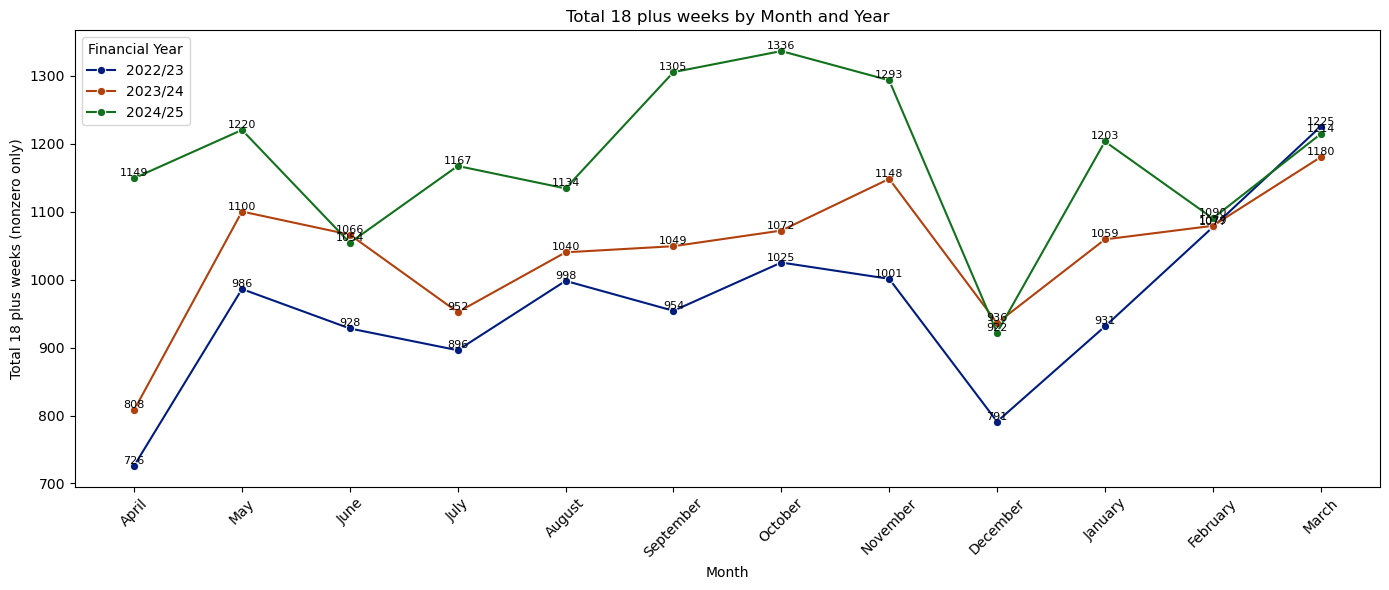

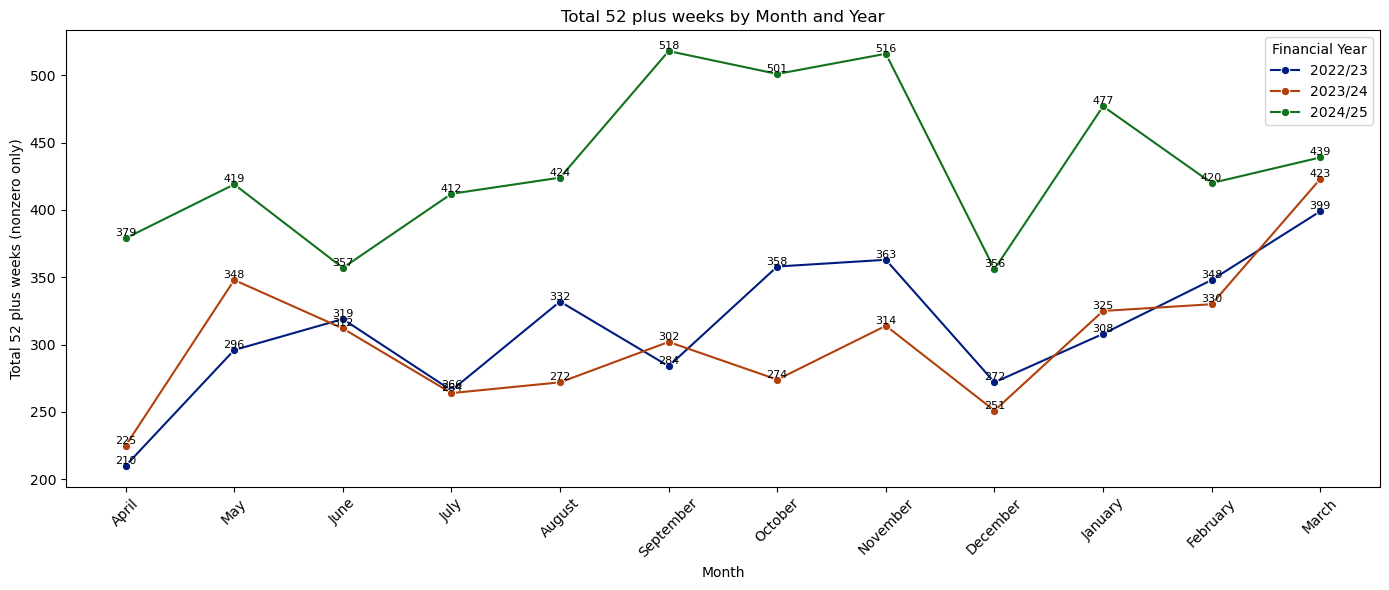

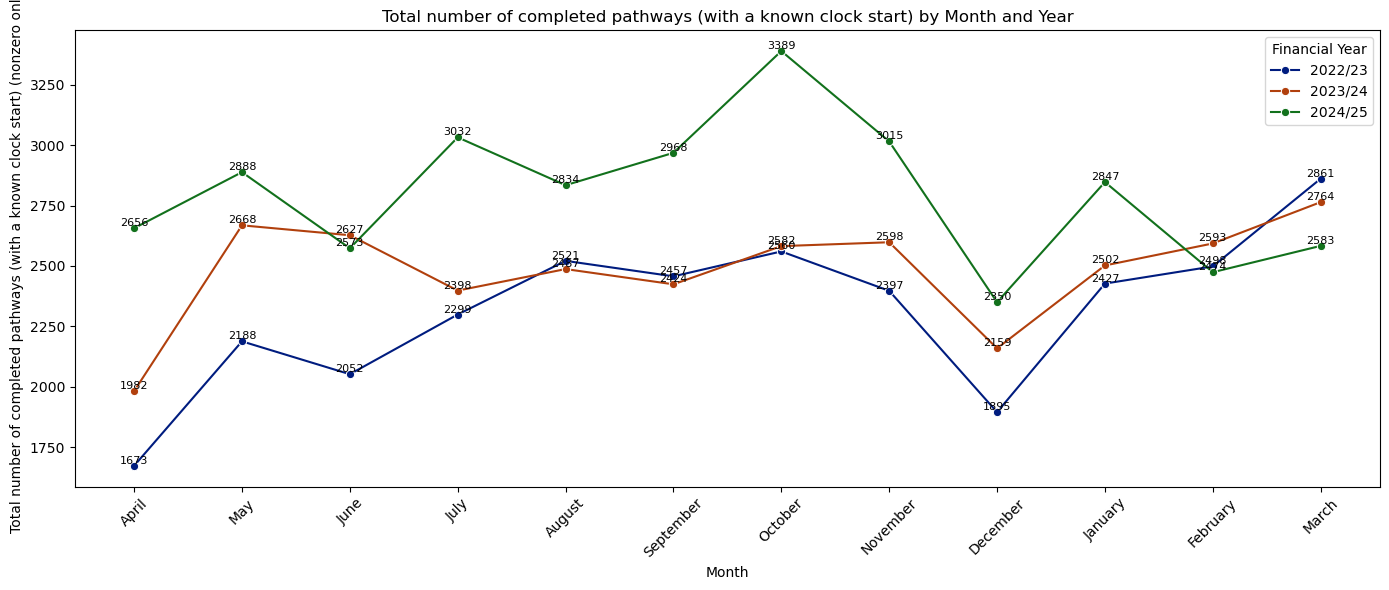

In [346]:
plot_trends_by_column(plot_df_18plus, 'Total 18 plus weeks')
plot_trends_by_column(plot_df_52plus, 'Total 52 plus weeks')
plot_trends_by_column(plot_df_total, 'Total number of completed pathways (with a known clock start)')

In [347]:
num_unique_treatment_functions = data_df['Treatment Function'].nunique()
print(f"There are {num_unique_treatment_functions} unique values in 'Treatment Function' column.")

There are 22 unique values in 'Treatment Function' column.


<!-- ## Sort the dataframes by Treatment Function and Month Year to preserve temporal order. -->

In [348]:
def sort_df (df):
    """
    Sorts the DataFrame by specified columns.
    
    Args:
        df (pd.DataFrame): DataFrame to sort
        sort_by (list): List of columns to sort by
        
    Returns:
        pd.DataFrame: Sorted DataFrame
    """
    return df.sort_values(by=['Treatment Function', 'MonthYear'], inplace=True)
sort_df(waits_18plus_df)
sort_df(waits_52plus_df)
sort_df(total_pathways_df)

In [349]:
data_18plus = waits_18plus_df.reset_index()
data_52plus = waits_52plus_df.reset_index()
data_total = total_pathways_df.reset_index()

## Create the future dates dataframe with Treatment Functions

In [350]:
# Create dataframe for future Months till March 2026
future_months = pd.date_range(start='2025-04-01', end='2026-03-01', freq='MS')
future_df = pd.DataFrame(future_months, columns=['Month'])
future_df['Year'] = future_df['Month'].dt.year
future_df['Month_Sin'] = np.sin(2 * np.pi * future_df['Month'].dt.month / 12)
future_df['Month_Cos'] = np.cos(2 * np.pi * future_df['Month'].dt.month / 12)
future_df['MonthName'] = future_df['Month'].dt.month_name()


In [351]:
# Get all unique Treatment Functions
treatment_functions = sorted(data_df['Treatment Function'].unique())

# Create a MultiIndex of all combinations of future months and treatment functions
multi_index = pd.MultiIndex.from_product(
    [future_df['Month'], treatment_functions],
    names=['Month', 'Treatment Function']
)

# Create the expanded DataFrame
future_expanded_df = pd.DataFrame(index=multi_index).reset_index()

# Merge with future_df to add time features
future_expanded_df = future_expanded_df.merge(
    future_df,
    left_on='Month',
    right_on='Month',
    how='left'
)



## One Hot Encoding Treatment Functions

In [352]:
def encode_treatment_function(df):
    """
    Performs one-hot encoding specifically on the 'Treatment Function' column.
    
    Args:
        df (pd.DataFrame): Input DataFrame containing 'Treatment Function' column

    Returns:
        pd.DataFrame: DataFrame with one-hot encoded treatment functions
    """

    # Initialize and fit encoder
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(df[['Treatment Function']])
    
    # Create encoded DataFrame
    encoded_df = pd.DataFrame(
        encoded_data,
        columns=encoder.get_feature_names_out(['Treatment Function']),
        index=df.index  # Preserve original index
    )
     # Concatenate with original DataFrame
    combined_df = pd.concat([df, encoded_df], axis=1)

    return combined_df

In [353]:
data_18plus_concat = encode_treatment_function(data_18plus)
data_52plus_concat = encode_treatment_function(data_52plus)
data_total_concat = encode_treatment_function(data_total)
future_expanded_concat = encode_treatment_function(future_expanded_df)

<!-- ## Testing the One Hot Encoding of Treatment Function -->

In [354]:
filtered_df = data_18plus_concat[data_18plus_concat['Treatment Function'] == 'Cardiology Service']
# Get distinct values of both columns
distinct_values = {
    'Treatment Function': filtered_df['Treatment Function'].unique(),
    'Treatment Function_Cardiology Service': filtered_df['Treatment Function_Cardiology Service'].unique()
}
pprint(distinct_values)

{'Treatment Function': array(['Cardiology Service'], dtype=object),
 'Treatment Function_Cardiology Service': array([1.])}


In [355]:
def add_lags(df, target_col):
    target_map = df[target_col].to_dict()
    
  # Case 2: Numeric index (assume uniform monthly steps)
    df['lag_1'] = df[target_col].shift(1)
    df['lag_2'] = df[target_col].shift(2)
    df['lag_3'] = df[target_col].shift(3)
    
    return df

In [356]:
data_18plus_lagged = add_lags(data_18plus_concat, 'Total 18 plus weeks')
data_52plus_lagged = add_lags(data_52plus_concat, 'Total 52 plus weeks')
data_total_lagged = add_lags(data_total_concat, 'Total number of completed pathways (with a known clock start)')

## Create Lagged features for future dataset

In [357]:
future_expanded_concat = future_expanded_concat.set_index('Month')
future_expanded_concat = future_expanded_concat.drop(columns=['Treatment Function', 'MonthName'])

In [358]:

# Full data for prediction
data_18plus_lagged.set_index('MonthYear', inplace=True)
data_52plus_lagged.set_index('MonthYear', inplace=True)
data_total_lagged.set_index('MonthYear', inplace=True)


In [359]:

def add_time_features(df):
    """
    Adds time-based features to the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame with datetime index
        
    Returns:
        pd.DataFrame: DataFrame with additional time features
    """
    df['Month_Sin'] = np.sin(2 * np.pi * df.index.month / 12)   
    df['Month_Cos'] = np.cos(2 * np.pi * df.index.month/ 12)
    df['Year'] = df.index.year
    return df

data_18plus_lagged = add_time_features(data_18plus_lagged)
data_52plus_lagged = add_time_features(data_52plus_lagged)
data_total_lagged = add_time_features(data_total_lagged)


In [360]:
def train_test_split_data(df):
    """
    Splits the DataFrame into training and testing sets.
    
    Args:
        data (pd.DataFrame): DataFrame to split
        test_size (float): Proportion of data to include in the test set
        
    Returns:
        tuple: Training and testing DataFrames
    """
    train_size = int(len(df) * 0.8)
    df_train = df[:train_size]
    df_test = df[train_size:]
    return df_train, df_test


data_18plus_train, data_18plus_test = train_test_split_data(data_18plus_lagged)
data_52plus_train, data_52plus_test = train_test_split_data(data_52plus_lagged)
data_total_train, data_total_test = train_test_split_data(data_total_lagged)

In [361]:
print(data_18plus_train.shape, data_18plus_test.shape)
print(data_52plus_train.shape, data_52plus_test.shape)
print(data_total_train.shape, data_total_test.shape)

(633, 30) (159, 30)
(633, 30) (159, 30)
(633, 30) (159, 30)


In [362]:
def get_x_y(df, target_column):
    """
    Splits the DataFrame into features (X) and target (y).
    
    Args:
        df (pd.DataFrame): DataFrame to split
        target_column (str): Name of the target column
        
    Returns:
        tuple: Features DataFrame and target Series
    """
    X = df.drop(columns=[target_column, 'Treatment Function'], axis=1)
    y = df[target_column]
    return X, y

In [363]:
X_18plus_train, Y_18plus_train = get_x_y(data_18plus_train, 'Total 18 plus weeks')
X_18plus_test, Y_18plus_test = get_x_y(data_18plus_test, 'Total 18 plus weeks')
X_52plus_train, Y_52plus_train = get_x_y(data_52plus_train, 'Total 52 plus weeks')
X_52plus_test, Y_52plus_test = get_x_y(data_52plus_test, 'Total 52 plus weeks')
X_total_train, Y_total_train = get_x_y(data_total_train, 'Total number of completed pathways (with a known clock start)')
X_total_test, Y_total_test = get_x_y(data_total_test, 'Total number of completed pathways (with a known clock start)')

<!-- ## Model total 18 plus Waits -->

In [364]:
model_18plus = XGBRegressor(
    objective='count:poisson',
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    reg_alpha=0,
    reg_lambda=0.7,
    enable_categorical=False,
    random_state=42,
    early_stopping_rounds=20
)

# With early stopping rounds
model_18plus.fit(
    X_18plus_train, 
    Y_18plus_train,
    eval_set=[(X_18plus_test, Y_18plus_test)] ,
    verbose=10
)

[0]	validation_0-poisson-nloglik:24.14620
[10]	validation_0-poisson-nloglik:19.04959
[20]	validation_0-poisson-nloglik:15.17852
[30]	validation_0-poisson-nloglik:12.26902
[40]	validation_0-poisson-nloglik:10.10265
[50]	validation_0-poisson-nloglik:8.46541
[60]	validation_0-poisson-nloglik:7.25097
[70]	validation_0-poisson-nloglik:6.37341
[80]	validation_0-poisson-nloglik:5.73676
[90]	validation_0-poisson-nloglik:5.28346
[100]	validation_0-poisson-nloglik:4.96249
[110]	validation_0-poisson-nloglik:4.74835
[120]	validation_0-poisson-nloglik:4.63739
[130]	validation_0-poisson-nloglik:4.59270
[140]	validation_0-poisson-nloglik:4.57942
[150]	validation_0-poisson-nloglik:4.59327
[159]	validation_0-poisson-nloglik:4.61997


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

<!-- ## Model for 52 Weeks Waits -->

In [365]:


def suggest_xgb_poisson(trial):
    return {
        'objective': 'count:poisson',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1600),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2.0),
        'early_stopping_rounds': 30,
        'random_state': 42,
        'enable_categorical': False
    }
def objective(trial):
    params = suggest_xgb_poisson(trial)
    
    model = XGBRegressor(**params)
    model.fit(
        X_52plus_train, Y_52plus_train,
        eval_set=[(X_52plus_test, Y_52plus_test)],
        verbose=0
    )

    preds = model.predict(X_52plus_test)
    return mean_squared_error(Y_52plus_test, preds)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best parameters:")
print(study.best_params)

[I 2025-06-10 00:27:58,413] A new study created in memory with name: no-name-eea2ed69-8704-4bcf-bfc5-75591935f836
[I 2025-06-10 00:27:58,623] Trial 0 finished with value: 17.412964397288686 and parameters: {'learning_rate': 0.02302349818675822, 'n_estimators': 715, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.6601058456940153, 'subsample': 0.5923734355066479, 'colsample_bytree': 0.8909814029907397, 'reg_alpha': 0.4145679995562155, 'reg_lambda': 1.263745077922637}. Best is trial 0 with value: 17.412964397288686.
[I 2025-06-10 00:27:58,740] Trial 1 finished with value: 18.73414728939827 and parameters: {'learning_rate': 0.057638762869691204, 'n_estimators': 1034, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.9516952317113212, 'subsample': 0.6522642990522267, 'colsample_bytree': 0.6687336731170788, 'reg_alpha': 0.8986910109687724, 'reg_lambda': 0.5966013184276894}. Best is trial 0 with value: 17.412964397288686.
[I 2025-06-10 00:27:58,823] Trial 2 finished with value: 17.69084126

Best parameters:
{'learning_rate': 0.050147517062586584, 'n_estimators': 509, 'max_depth': 4, 'min_child_weight': 7, 'gamma': 0.6112358707876593, 'subsample': 0.521592125573985, 'colsample_bytree': 0.9223127263081456, 'reg_alpha': 0.8643807393298799, 'reg_lambda': 1.236307129609744}


In [366]:
model_52plus = XGBRegressor(objective='count:poisson',
                            early_stopping_rounds=30,
        random_state=42,
        enable_categorical=False,
                        **study.best_params)

# With early stopping rounds
model_52plus.fit(
    X_52plus_train, 
    Y_52plus_train,
    eval_set=[(X_52plus_test, Y_52plus_test)] ,
    verbose=10
)

[0]	validation_0-poisson-nloglik:9.24648
[10]	validation_0-poisson-nloglik:7.56776
[20]	validation_0-poisson-nloglik:6.29016
[30]	validation_0-poisson-nloglik:5.30809
[40]	validation_0-poisson-nloglik:4.55495
[50]	validation_0-poisson-nloglik:3.98093
[60]	validation_0-poisson-nloglik:3.53529
[70]	validation_0-poisson-nloglik:3.20329
[80]	validation_0-poisson-nloglik:2.93894
[90]	validation_0-poisson-nloglik:2.75258
[100]	validation_0-poisson-nloglik:2.61070
[110]	validation_0-poisson-nloglik:2.49792
[120]	validation_0-poisson-nloglik:2.41512
[130]	validation_0-poisson-nloglik:2.35836
[140]	validation_0-poisson-nloglik:2.33220
[150]	validation_0-poisson-nloglik:2.30488
[160]	validation_0-poisson-nloglik:2.29626
[170]	validation_0-poisson-nloglik:2.28400
[180]	validation_0-poisson-nloglik:2.27904
[190]	validation_0-poisson-nloglik:2.27391
[200]	validation_0-poisson-nloglik:2.26642
[210]	validation_0-poisson-nloglik:2.26554
[220]	validation_0-poisson-nloglik:2.26356
[230]	validation_0-poi

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9223127263081456, device=None,
             early_stopping_rounds=30, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.6112358707876593, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.050147517062586584,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=509, n_jobs=None,
             num_parallel_tree=None, ...)

<!-- ## Model for total pathways -->

In [367]:
model_total = XGBRegressor(
    objective='count:poisson',
    n_estimators=400,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    reg_alpha=0,
    reg_lambda=0.7,
    gamma=0.1,
    min_child_weight=1,
    enable_categorical=False,
    random_state=42,
    early_stopping_rounds=20
)

# With early stopping rounds
model_total.fit(
    X_total_train, 
    Y_total_train,
    eval_set=[(X_total_test, Y_total_test)] ,
    verbose=10
)

[0]	validation_0-poisson-nloglik:43.87636
[10]	validation_0-poisson-nloglik:37.84275
[20]	validation_0-poisson-nloglik:32.78774
[30]	validation_0-poisson-nloglik:28.55513
[40]	validation_0-poisson-nloglik:25.02264
[50]	validation_0-poisson-nloglik:22.14895
[60]	validation_0-poisson-nloglik:19.66160
[70]	validation_0-poisson-nloglik:17.61422
[80]	validation_0-poisson-nloglik:15.89998
[90]	validation_0-poisson-nloglik:14.46982
[100]	validation_0-poisson-nloglik:13.24534
[110]	validation_0-poisson-nloglik:12.23921
[120]	validation_0-poisson-nloglik:11.43881
[130]	validation_0-poisson-nloglik:10.74724
[140]	validation_0-poisson-nloglik:10.21713
[150]	validation_0-poisson-nloglik:9.78789
[160]	validation_0-poisson-nloglik:9.44023
[170]	validation_0-poisson-nloglik:9.17227
[180]	validation_0-poisson-nloglik:8.98457
[190]	validation_0-poisson-nloglik:8.81703
[200]	validation_0-poisson-nloglik:8.69596
[210]	validation_0-poisson-nloglik:8.59165
[220]	validation_0-poisson-nloglik:8.52128
[230]	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

<!-- ## Process the predictions for test dataset -->

In [368]:
def process_predictions(x_test_df, model):
    x_test_df['predictions'] = model.predict(x_test_df)
    x_test_df.drop(columns=['lag_1', 'lag_2', 'lag_3', 'Month_Sin', 'Month_Cos', 'Year'], inplace=True)
    x_test_df['Treatment Function'] = (x_test_df[x_test_df.columns[:-1]] == 1).idxmax(axis=1)
    x_test_df['Treatment Function'] = x_test_df['Treatment Function'].str.replace('Treatment Function_', '', regex=False)
    validate_df = x_test_df[['Treatment Function', 'predictions']]
    return validate_df


In [369]:
validate_18plus = process_predictions(X_18plus_test,model_18plus)
validate_52plus = process_predictions(X_52plus_test,model_52plus)
validate_total = process_predictions(X_total_test, model_total)

In [370]:

final_18plus = pd.concat([validate_18plus, Y_18plus_test], axis=1)
final_18plus['Error'] = final_18plus['predictions'] - final_18plus['Total 18 plus weeks']
final_52plus = pd.concat([validate_52plus, Y_52plus_test], axis=1)
final_52plus['Error'] = final_52plus['predictions'] - final_52plus['Total 52 plus weeks']
final_total = pd.concat([validate_total, Y_total_test], axis=1)
final_total['Error'] = final_total['predictions'] - final_total['Total number of completed pathways (with a known clock start)']

In [371]:
validation_plot_df_18plus = final_18plus[['predictions', 'Total 18 plus weeks']].reset_index()
validation_plot_df_18plus['MonthYear'] = validation_plot_df_18plus['MonthYear'].dt.strftime('%Y-%m')
validation_plot_df_18plus = validation_plot_df_18plus.groupby('MonthYear').sum()

# repeat for 52+ weeks and total pathways
validation_plot_df_52plus = final_52plus[['predictions', 'Total 52 plus weeks']].reset_index()
validation_plot_df_52plus['MonthYear'] = validation_plot_df_52plus['MonthYear'].dt.strftime('%Y-%m')
validation_plot_df_52plus = validation_plot_df_52plus.groupby('MonthYear').sum()
#total pathways
validation_plot_df_total = final_total[['predictions', 'Total number of completed pathways (with a known clock start)']].reset_index()
validation_plot_df_total['MonthYear'] = validation_plot_df_total['MonthYear'].dt.strftime('%Y-%m')
validation_plot_df_total = validation_plot_df_total.groupby('MonthYear').sum()  


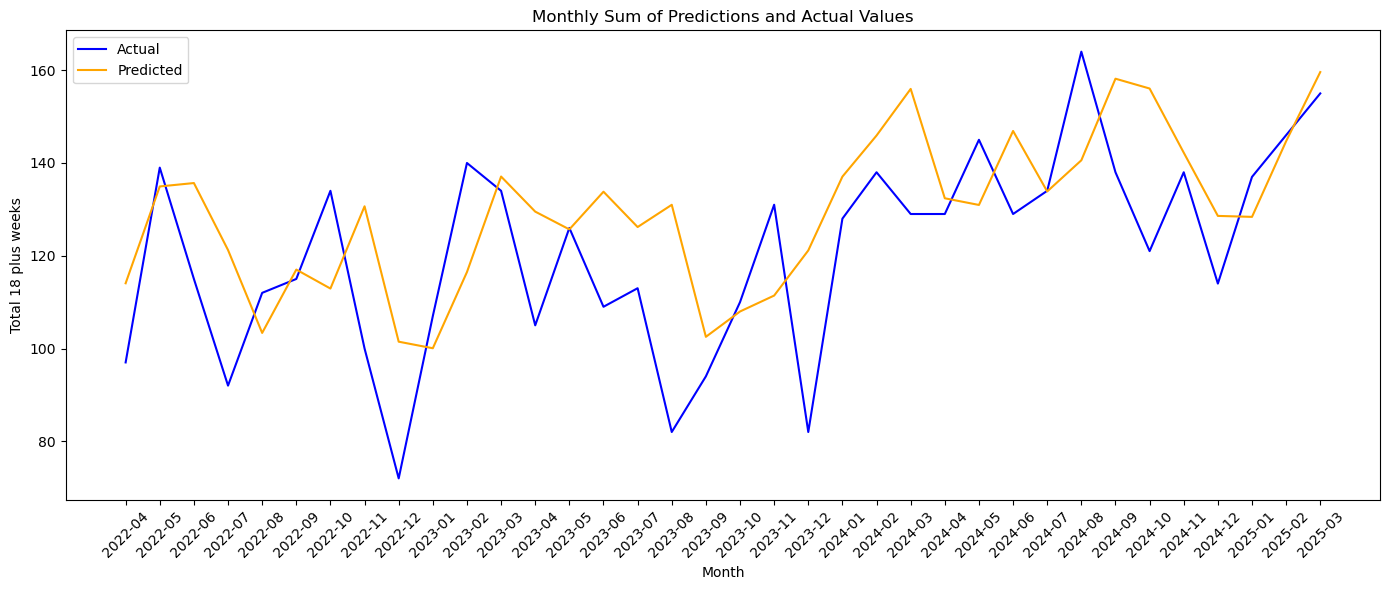

In [372]:
plt.figure(figsize=(14, 6))
plt.plot(validation_plot_df_18plus['Total 18 plus weeks'], label='Actual', color='blue')
plt.plot(validation_plot_df_18plus['predictions'], label='Predicted', color='orange')
plt.title('Monthly Sum of Predictions and Actual Values')
plt.xlabel('Month')
plt.ylabel('Total 18 plus weeks')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.legend()
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()

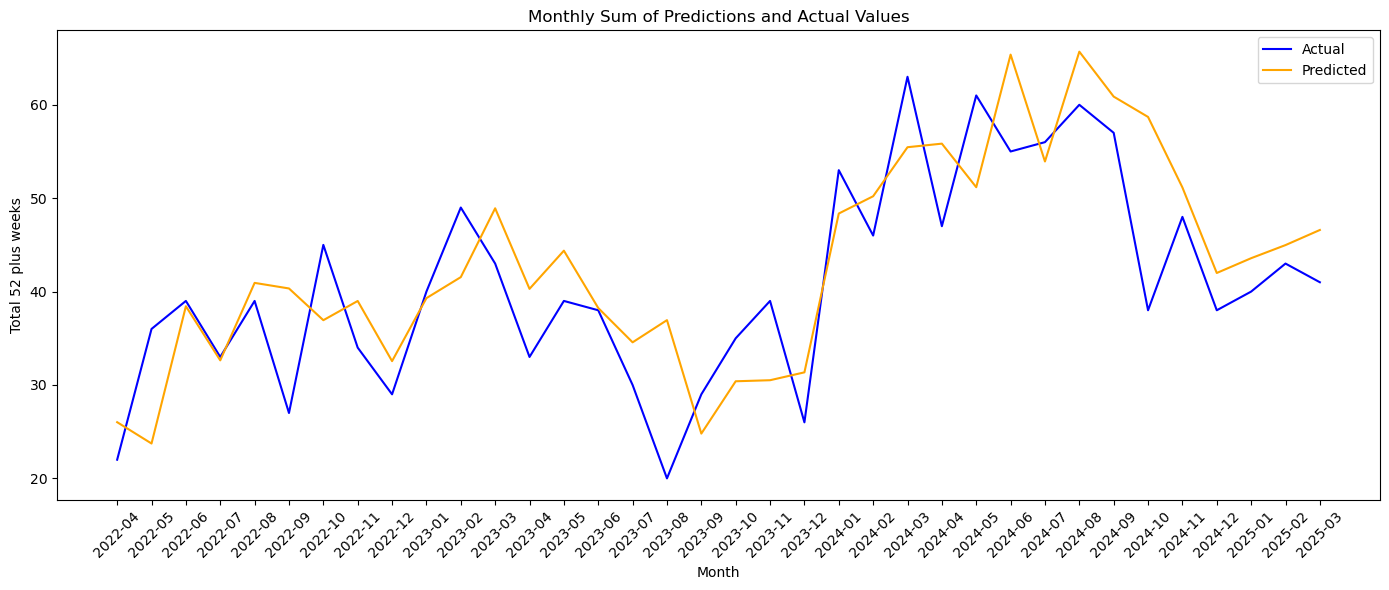

In [373]:
plt.figure(figsize=(14, 6))
plt.plot(validation_plot_df_52plus['Total 52 plus weeks'], label='Actual', color='blue')
plt.plot(validation_plot_df_52plus['predictions'], label='Predicted', color='orange')
plt.title('Monthly Sum of Predictions and Actual Values')
plt.xlabel('Month')
plt.ylabel('Total 52 plus weeks')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.legend()
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()

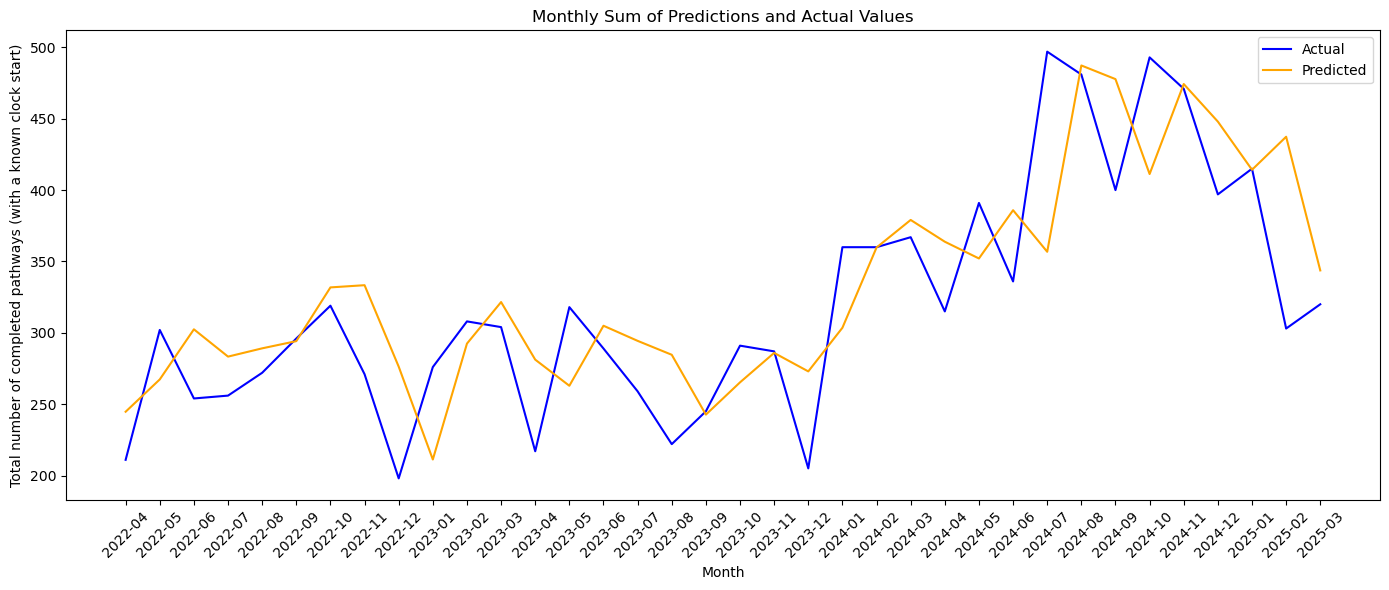

In [374]:
plt.figure(figsize=(14, 6))
plt.plot(validation_plot_df_total['Total number of completed pathways (with a known clock start)'], label='Actual', color='blue')
plt.plot(validation_plot_df_total['predictions'], label='Predicted', color='orange')
plt.title('Monthly Sum of Predictions and Actual Values')
plt.xlabel('Month')
plt.ylabel('Total number of completed pathways (with a known clock start)')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.legend()
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()

<!-- ## Evaluation of the Model
- Mean Squared error
- Mean Absolute Error
- Use MSE and MAE to compare predicted values to the test response values. -->

In [375]:
mse = mean_squared_error(Y_18plus_test, X_18plus_test['predictions'])
mae = mean_absolute_error(Y_18plus_test, X_18plus_test['predictions'])
r_square = r2_score(Y_18plus_test, X_18plus_test['predictions'])
print("Model Evaluation Metrics for 18+ Weeks Waits:")
print(f'R-squared: {r_square:.2f}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Model Evaluation Metrics for 18+ Weeks Waits:
R-squared: 0.83
Mean Squared Error: 122.28700528887586
Mean Absolute Error: 6.890916106835851


<!-- ## Model Evaluation Metrics for 52+ Weeks Waits -->

In [376]:
mse = mean_squared_error(Y_52plus_test, X_52plus_test['predictions'])
mae = mean_absolute_error(Y_52plus_test, X_52plus_test['predictions'])
r_square = r2_score(Y_52plus_test, X_52plus_test['predictions'])
print("Model Evaluation Metrics for 52+ Weeks Waits:")
print(f'R-squared: {r_square:.2f}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Model Evaluation Metrics for 52+ Weeks Waits:
R-squared: 0.81
Mean Squared Error: 16.28948091759106
Mean Absolute Error: 2.483977846004678


<!-- ## Model Evaluation Metrics for Total Pathways: -->

In [377]:
mse = mean_squared_error(Y_total_test, X_total_test['predictions'])
mae = mean_absolute_error(Y_total_test, X_total_test['predictions'])
r_square = r2_score(Y_total_test, X_total_test['predictions'])
print("Model Evaluation Metrics for Total Pathways:")
print(f'R-squared: {r_square:.2f}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Model Evaluation Metrics for Total Pathways:
R-squared: 0.80
Mean Squared Error: 666.3786422243288
Mean Absolute Error: 16.604865182120847


model_18plus
model_52plus
model_total

In [378]:
data_18plus_future = data_18plus_concat.drop('Treatment Function', axis=1)
# data_18plus_future.set_index('MonthYear', inplace=True)
# data_18plus_future = add_time_features(data_18plus_future)
# Do the same for 52+ weeks and total pathways
data_52plus_future = data_52plus_concat.drop('Treatment Function', axis=1)
# data_52plus_future.set_index('MonthYear', inplace=True)
# data_52plus_future = add_time_features(data_52plus_future)
data_total_future = data_total_concat.drop('Treatment Function', axis=1)
# data_total_future.set_index('MonthYear', inplace=True)
# data_total_future = add_time_features(data_total_future)

In [379]:
X_18plus_all = data_18plus_future.drop('Total 18 plus weeks', axis=1)
Y_18plus_all = data_18plus_future['Total 18 plus weeks']
X_52plus_all = data_52plus_future.drop('Total 52 plus weeks', axis=1)
Y_52plus_all = data_52plus_future['Total 52 plus weeks']
X_total_all = data_total_future.drop('Total number of completed pathways (with a known clock start)', axis=1)
Y_total_all = data_total_future['Total number of completed pathways (with a known clock start)']    

In [380]:
# fit the model for full dataset
model_18plus.fit(
    X_18plus_all, 
    Y_18plus_all,
    eval_set=[(X_18plus_all, Y_18plus_all)] ,
    verbose=100)
model_52plus.fit(
    X_52plus_all, 
    Y_52plus_all,
    eval_set=[(X_52plus_all, Y_52plus_all)] ,
    verbose=100)
model_total.fit(
    X_total_all, 
    Y_total_all,
    eval_set=[(X_total_all, Y_total_all)] ,
    verbose=100)

[0]	validation_0-poisson-nloglik:27.42307
[100]	validation_0-poisson-nloglik:3.89431
[200]	validation_0-poisson-nloglik:2.85704
[300]	validation_0-poisson-nloglik:2.65970
[399]	validation_0-poisson-nloglik:2.50634
[0]	validation_0-poisson-nloglik:12.97210
[100]	validation_0-poisson-nloglik:2.88726
[200]	validation_0-poisson-nloglik:2.41079
[300]	validation_0-poisson-nloglik:2.26111
[400]	validation_0-poisson-nloglik:2.15702
[500]	validation_0-poisson-nloglik:2.07273
[508]	validation_0-poisson-nloglik:2.06694
[0]	validation_0-poisson-nloglik:61.11458
[100]	validation_0-poisson-nloglik:12.09840
[200]	validation_0-poisson-nloglik:6.23513
[300]	validation_0-poisson-nloglik:5.08676
[399]	validation_0-poisson-nloglik:4.71224


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

## Forecast 18 plus weeks Waits

In [381]:
data_total_lagged.drop('Treatment Function', axis=1, inplace=True)
data_18plus_lagged.drop('Treatment Function', axis=1, inplace=True)
data_52plus_lagged.drop('Treatment Function', axis=1, inplace=True)


In [382]:
future_lag1 = future_expanded_concat.loc[future_expanded_concat.index.min(),].reset_index(drop=False)
future_lag_values1 = data_18plus_lagged.loc[data_18plus_lagged.index.max(),][['lag_1', 'lag_2', 'lag_3']].reset_index(drop=False)
future_lag_values52 = data_52plus_lagged.loc[data_52plus_lagged.index.max(),][['lag_1', 'lag_2', 'lag_3']].reset_index(drop=False)
future_lag_values_total = data_total_lagged.loc[data_total_lagged.index.max(),][['lag_1', 'lag_2', 'lag_3']].reset_index(drop=False)
future_lag1[['lag_1', 'lag_2', 'lag_3']] = future_lag_values1[['lag_1', 'lag_2', 'lag_3']]
future_lag52 = future_lag1.copy()
future_lag_total = future_lag1.copy()

future_lag52[['lag_1', 'lag_2', 'lag_3']] = future_lag_values52[['lag_1', 'lag_2', 'lag_3']]
future_lag_total[['lag_1', 'lag_2', 'lag_3']] = future_lag_values_total[['lag_1', 'lag_2', 'lag_3']]


In [383]:
future_lag1.set_index('Month', inplace=True)
future_lag52.set_index('Month', inplace=True)
future_lag_total.set_index('Month', inplace=True)

In [384]:
expected_features = model_18plus.get_booster().feature_names
future_lag1 = future_lag1.reindex(columns=expected_features)
future_lag52 = future_lag52.reindex(columns=expected_features)
future_lag_total = future_lag_total.reindex(columns=expected_features)


In [385]:
future_lag1['Total 18 plus weeks'] = model_18plus.predict(future_lag1)
future_lag52['Total 52 plus weeks'] = model_52plus.predict(future_lag52)
future_lag_total['Total number of completed pathways (with a known clock start)'] = model_total.predict(future_lag_total)

In [386]:
future_lag1.reset_index(inplace=True)
future_lag52.reset_index(inplace=True)
future_lag_total.reset_index(inplace=True)

In [387]:
all_months_except_first = (future_expanded_concat[future_expanded_concat.index != future_expanded_concat.index.min()]).reset_index(drop=False)

In [388]:
future_df_2 = pd.concat([future_lag1,all_months_except_first], axis=0)
future_df_52 = pd.concat([future_lag52,all_months_except_first], axis=0)
future_df_total = pd.concat([future_lag_total,all_months_except_first], axis=0)

In [389]:
future_df_2.reset_index(drop=True, inplace=True)
future_df_52.reset_index(drop=True, inplace=True)
future_df_total.reset_index(drop=True, inplace=True)

In [390]:
future_df_18plus = future_df_2.drop('Month', axis=1)
future_df_52plus = future_df_52.drop('Month', axis=1)
future_df_total_plus = future_df_total.drop('Month', axis=1)

In [391]:
# Column order expected by the model
feature_cols = model_18plus.get_booster().feature_names

for i in range(len(future_df_18plus)):
    # ─── 1. Update lags ──────────────────────────────────────────
    if i >= 22:                                   # rows 0-21 already seeded
        future_df_18plus.at[i, 'lag_1'] = future_df_18plus.at[i-1, 'Total 18 plus weeks']
        future_df_18plus.at[i, 'lag_2'] = future_df_18plus.at[i-1, 'lag_1']
        future_df_18plus.at[i, 'lag_3'] = future_df_18plus.at[i-1, 'lag_2']

    # ─── 2. Build feature vector for this row ───────────────────
    X = (future_df_18plus
            .loc[[i]]                          # keep as DataFrame, not Series
            .drop(columns='Total 18 plus weeks')
            .reindex(columns=feature_cols, fill_value=0))

    # ─── 3. Predict and store ───────────────────────────────────
    pred = model_18plus.predict(X)[0]          # scalar
    future_df_18plus.at[i, 'Total 18 plus weeks'] = pred

In [392]:
# Column order expected by the model
feature_cols = model_52plus.get_booster().feature_names

for i in range(len(future_df_52plus)):
    # ─── 1. Update lags ──────────────────────────────────────────
    if i >= 22:                                   # rows 0-21 already seeded
        future_df_52plus.at[i, 'lag_1'] = future_df_52plus.at[i-1, 'Total 52 plus weeks']
        future_df_52plus.at[i, 'lag_2'] = future_df_52plus.at[i-1, 'lag_1']
        future_df_52plus.at[i, 'lag_3'] = future_df_52plus.at[i-1, 'lag_2']

    # ─── 2. Build feature vector for this row ───────────────────
    X = (future_df_52plus
            .loc[[i]]                          # keep as DataFrame, not Series
            .drop(columns='Total 52 plus weeks')
            .reindex(columns=feature_cols, fill_value=0))

    # ─── 3. Predict and store ───────────────────────────────────
    pred = model_52plus.predict(X)[0]          # scalar
    future_df_52plus.at[i, 'Total 52 plus weeks'] = pred

In [393]:
# Column order expected by the model
feature_cols = model_total.get_booster().feature_names

for i in range(len(future_df_total_plus)):
    # ─── 1. Update lags ──────────────────────────────────────────
    if i >= 22:                                   # rows 0-21 already seeded
        future_df_total_plus.at[i, 'lag_1'] = future_df_total_plus.at[i-1, 'Total number of completed pathways (with a known clock start)']
        future_df_total_plus.at[i, 'lag_2'] = future_df_total_plus.at[i-1, 'lag_1']
        future_df_total_plus.at[i, 'lag_3'] = future_df_total_plus.at[i-1, 'lag_2']

    # ─── 2. Build feature vector for this row ───────────────────
    X = (future_df_total_plus
            .loc[[i]]                          # keep as DataFrame, not Series
            .drop(columns='Total number of completed pathways (with a known clock start)')
            .reindex(columns=feature_cols, fill_value=0))

    # ─── 3. Predict and store ───────────────────────────────────
    pred = model_total.predict(X)[0]          # scalar
    future_df_total_plus.at[i, 'Total number of completed pathways (with a known clock start)'] = pred

In [394]:

forecast_total = future_df_total_plus.join(future_df_total[['Month']], how='left')
forecast_52plus = future_df_52plus.join(future_df_52[['Month']], how='left')
forecast_18plus = future_df_18plus.join(future_df_2[['Month']], how='left')


In [395]:
forecast_total.set_index('Month', inplace=True)
forecast_52plus.set_index('Month', inplace=True)
forecast_18plus.set_index('Month', inplace=True)

In [396]:
def reverse_ohe(df):
    df['Treatment Function'] = (df[df.columns[:-7]] == 1).idxmax(axis=1)
    df['Treatment Function'] = df['Treatment Function'].str.replace('Treatment Function_', '', regex=False)
    return df[df.columns[-2:]]

In [397]:
last_df = pd.concat([reverse_ohe(forecast_52plus)[['Treatment Function', 'Total 52 plus weeks']],
            reverse_ohe(forecast_18plus)['Total 18 plus weeks'],
            reverse_ohe(forecast_total)['Total number of completed pathways (with a known clock start)']], axis = 1)
last_df = last_df.reset_index()

In [398]:
max_date = last_df['Month'].max()
answers_df = last_df.loc[last_df['Month'] == max_date]

In [399]:
answers_df['% of under 18 weeks waits'] = 100 - (answers_df['Total 18 plus weeks'] / answers_df['Total number of completed pathways (with a known clock start)']) * 100


C:\Users\ajays\AppData\Local\Temp\ipykernel_24980\793535098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df['% of under 18 weeks waits'] = 100 - (answers_df['Total 18 plus weeks'] / answers_df['Total number of completed pathways (with a known clock start)']) * 100


In [400]:
data_df['% of under 18 weeks waits'] = 100 - (data_df['Total 18 plus weeks'] / data_df['Total number of completed pathways (with a known clock start)']) * 100

In [401]:
answers_df['% of 52 plus weeks waits'] = (answers_df['Total 52 plus weeks'] / answers_df['Total number of completed pathways (with a known clock start)']) * 100

C:\Users\ajays\AppData\Local\Temp\ipykernel_24980\883733896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_df['% of 52 plus weeks waits'] = (answers_df['Total 52 plus weeks'] / answers_df['Total number of completed pathways (with a known clock start)']) * 100


C:\Users\ajays\AppData\Local\Temp\ipykernel_24980\2687258946.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


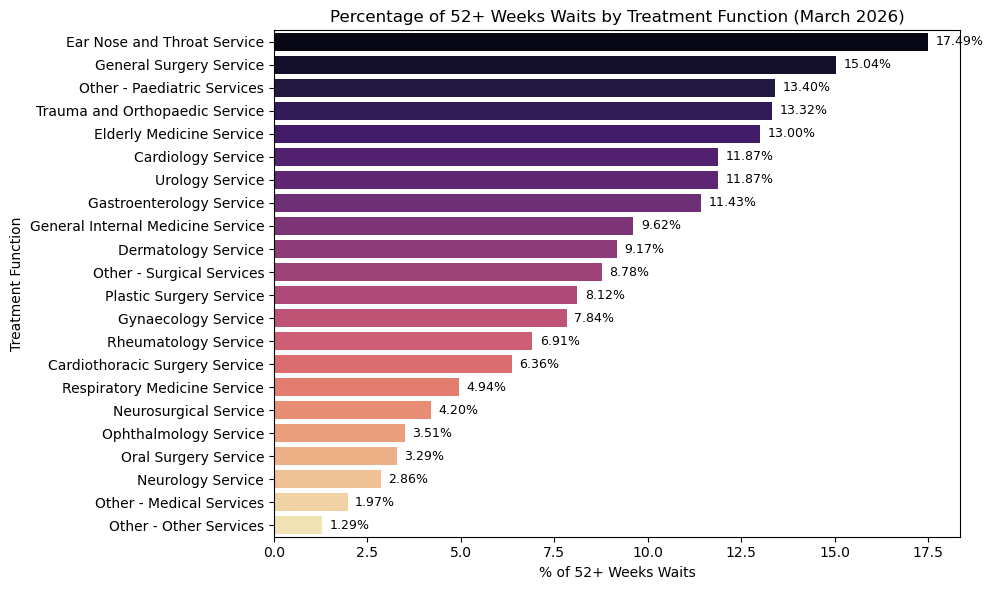

In [402]:
# Prepare data for plotting
percent_52plus = answers_df[['Treatment Function', '% of 52 plus weeks waits']].copy()
percent_52plus_sorted = percent_52plus.sort_values('% of 52 plus weeks waits', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='% of 52 plus weeks waits',
    y='Treatment Function',
    data=percent_52plus_sorted,
    palette='magma'
)
plt.xlabel('% of 52+ Weeks Waits')
plt.ylabel('Treatment Function')
plt.title('Percentage of 52+ Weeks Waits by Treatment Function (March 2026)')
for i, v in enumerate(percent_52plus_sorted['% of 52 plus weeks waits']):
    ax.text(v + 0.2, i, f'{v:.2f}%', va='center', fontsize=9)
plt.tight_layout()
plt.show()

C:\Users\ajays\AppData\Local\Temp\ipykernel_24980\2399517943.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


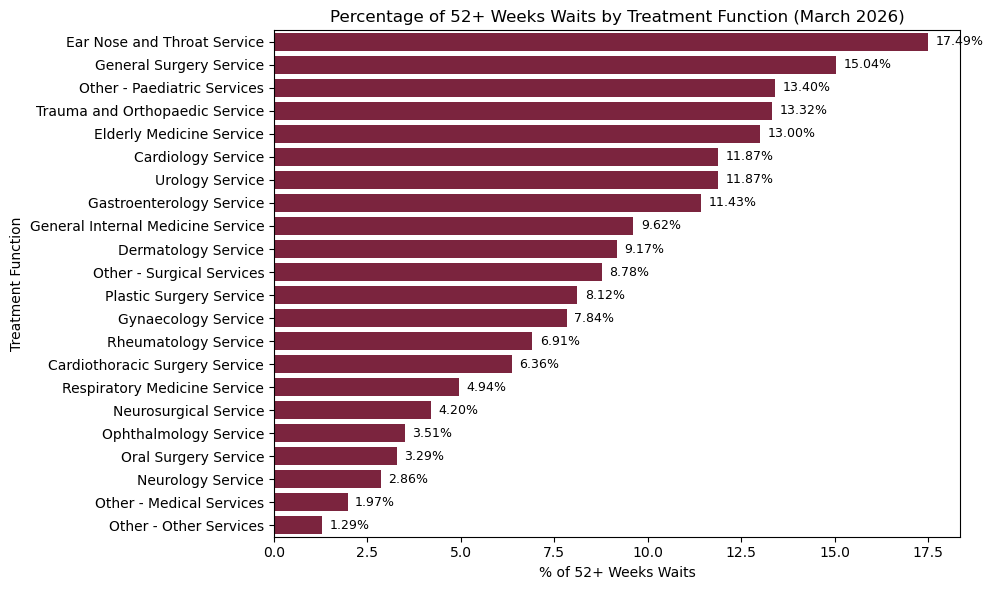

In [403]:
# Prepare data for plotting
percent_52plus = answers_df[['Treatment Function', '% of 52 plus weeks waits']].copy()
percent_52plus_sorted = percent_52plus.sort_values('% of 52 plus weeks waits', ascending=False)

# Define colors based on condition (green if <1, red otherwise)
colors = ['#00A499' if x < 1 else '#8A1538' for x in percent_52plus_sorted['% of 52 plus weeks waits']]

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='% of 52 plus weeks waits',
    y='Treatment Function',
    data=percent_52plus_sorted,
    palette=colors  # Apply custom colors
)
plt.xlabel('% of 52+ Weeks Waits')
plt.ylabel('Treatment Function')
plt.title('Percentage of 52+ Weeks Waits by Treatment Function (March 2026)')

# Add value labels
for i, v in enumerate(percent_52plus_sorted['% of 52 plus weeks waits']):
    ax.text(v + 0.2, i, f'{v:.2f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

C:\Users\ajays\AppData\Local\Temp\ipykernel_24980\1136866155.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


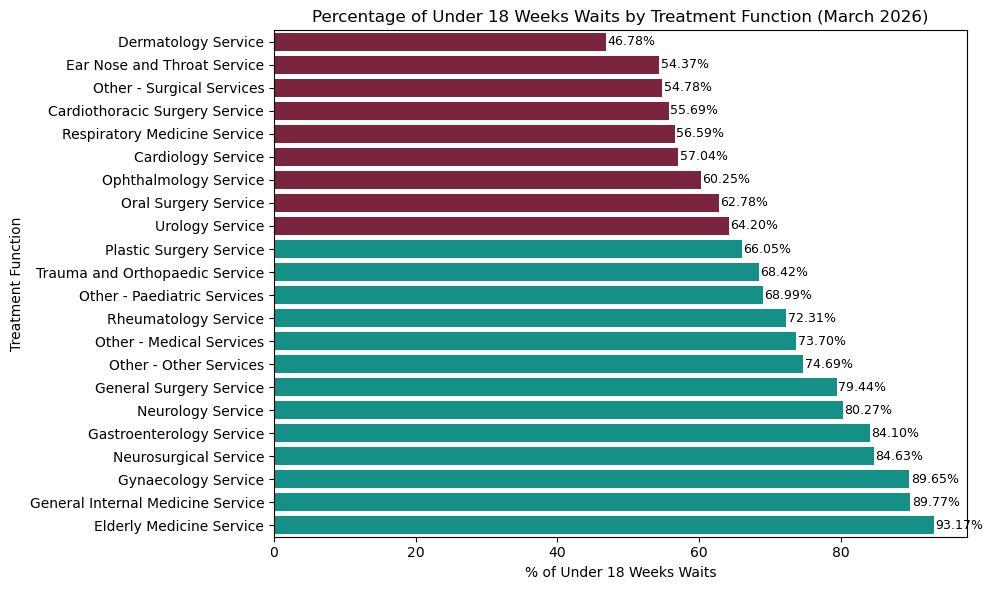

In [404]:
# Prepare data for plotting
percent_18plus = answers_df[['Treatment Function', '% of under 18 weeks waits']].copy()
percent_18plus_sorted = percent_18plus.sort_values('% of under 18 weeks waits', ascending=True)

# Define colors based on condition
colors = ['#00A499' if x > 65 else '#8A1538' for x in percent_18plus_sorted['% of under 18 weeks waits']]

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='% of under 18 weeks waits',
    y='Treatment Function',
    data=percent_18plus_sorted,
    palette=colors  # Apply custom colors
)
plt.xlabel('% of Under 18 Weeks Waits')
plt.ylabel('Treatment Function')
plt.title('Percentage of Under 18 Weeks Waits by Treatment Function (March 2026)')

# Add value labels
for i, v in enumerate(percent_18plus_sorted['% of under 18 weeks waits']):
    ax.text(v + 0.2, i, f'{v:.2f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()